### Import Dog Dataset

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/dogImages/valid')
test_files, test_targets = load_dataset('dogImages/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


### Detect humans

[[ 72  68 112 112]]
Number of faces detected: 1


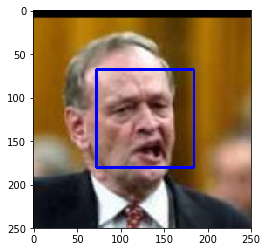

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[58])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)
print(faces)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Human face detector

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Obtain Bottleneck Features

In [6]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet = bottleneck_features['train']
valid_Resnet= bottleneck_features['valid']
test_Resnet = bottleneck_features['test']

### Model Architecture

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU

### TODO: Define your architecture.
from keras.models import Sequential
print(train_Resnet.shape)
Resnet = Sequential()
#Resnet.add(Flatten(input_shape = train_Resnet.shape[1:],name='top_layer_input' ))
Resnet.add(GlobalAveragePooling2D(name='global_average',input_shape = train_Resnet.shape[1:]))
Resnet.add(Dense(133, activation='softmax',name='prediction'))

Resnet.summary()

(6680, 1, 1, 2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average (GlobalAverag (None, 2048)              0         
_________________________________________________________________
prediction (Dense)           (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [8]:
### Compile the model.
Resnet.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [9]:
### Train the model.
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.RestNet.hdf5', 
                               verbose=1, save_best_only=True)

evaluation = Resnet.fit(train_Resnet, train_targets, 
          validation_data=(valid_Resnet, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 2s - loss: 1.6345 - acc: 0.5973 - val_loss: 0.8438 - val_acc: 0.7485
Epoch 2/50
6680/6680 [==============================] - 1s - loss: 0.4358 - acc: 0.8597 - val_loss: 0.7177 - val_acc: 0.7892
Epoch 3/50
6680/6680 [==============================] - 1s - loss: 0.2656 - acc: 0.9150 - val_loss: 0.6852 - val_acc: 0.8000
Epoch 4/50
6680/6680 [==============================] - 1s - loss: 0.1769 - acc: 0.9470 - val_loss: 0.6335 - val_acc: 0.8204
Epoch 5/50
6680/6680 [==============================] - 1s - loss: 0.1232 - acc: 0.9597 - val_loss: 0.6494 - val_acc: 0.8144
Epoch 6/50
6680/6680 [==============================] - 1s - loss: 0.0857 - acc: 0.9732 - val_loss: 0.7144 - val_acc: 0.8024
Epoch 7/50
6680/6680 [==============================] - 1s - loss: 0.0654 - acc: 0.9801 - val_loss: 0.6718 - val_acc: 0.8180
Epoch 8/50
6680/6680 [==============================] - 1s - loss: 0.0492 - ac

### Load the Model with the Best Validation Loss

In [10]:
### Load the model weights with the best validation loss.
# Resnet.load_weights('saved_models/weights.best.RestNet.hdf5')
Resnet.save('CNN_full.h5')

### Test the Model

In [11]:
### Calculate classification accuracy on the test dataset.
Resnet_predictions = [np.argmax(Resnet.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet_predictions)==np.argmax(test_targets, axis=1))/len(Resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.2201%


### Predict

In [12]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Resnet_predict_breed(img_path):
    # extract bottleneck features
    #print(img_path)
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

### (Optional) Complete the app

Done with loading ResNet50


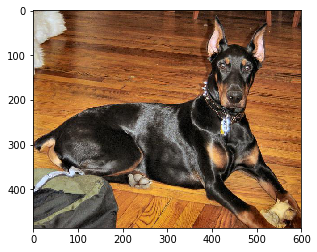

This is a dog: train/070.German_pinscher


In [22]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image  
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    #print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    #print( tqdm(img_paths))
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 


def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    #print(img_path)
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))


# define ResNet50 model
from keras.applications.resnet50 import ResNet50
ResNet50_model = ResNet50(weights='imagenet')
print("Done with loading ResNet50")

def tell_dog_breed(img):
    # read the image
    image = cv2.imread(img)
    # convert BGR image to RGB for plotting
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # display the image along with bounding box
    plt.imshow(color)
    plt.show()
    
    # predict the breed
    prediction = Resnet_predict_breed(img)
    
    # algorithm
    if dog_detector(img):
        print('This is a dog:', prediction)
    elif face_detector(img):
        print('This is a human...They look like a ', prediction)
    else:
        print('I have no clue!')
    
# Test
tell_dog_breed(test_files[1])

### The End